In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import sys
"push test"
'local_main rename test'
# sys.path.append(r'/Users/CHJ/文稿/无人机sar/yamakawa/pi_data/SAR_program')
import SA_func as sa

## 引数定義
ch = 8 # channel
ad_samp_point = 512  # レーダのレンジ方向サンプリング数
az_n = 2000 #アジマス方向のピクセル数
az_dt =0.01
light_speed = sa.light_speed
df = sa.df
dr = sa.dr
ad_samp_point = sa.ad_samp_point
chirp_rate = sa.chirp_rate
d_tau = df / chirp_rate 
dir_name = ""
add_name = ""
filename = "/Users/CHJ/文稿/无人机sar/yamakawa/pi_data/1206_data/azimuth_1/fft_data"

fft_data = sa.read_fft_data(filename)
data = sa.code_V_convert(fft_data)
raw_data = sa.get_raw_data(data)
index = [700, 1200, 0, 50]
az_s_index = index[0]
az_e_index = index[1]
az_len = az_e_index - az_s_index
rg_s_index = index[2]
rg_e_index = index[3]
rg_len = rg_e_index - rg_s_index
plt.figure(figsize = (12,8))

# ampを抽出,amp_dataはlog化データ
data = raw_data[0] #raw_data (8,2000,512)
amp_data = 20 * np.log10(np.abs(data[az_s_index:az_e_index, rg_s_index:rg_e_index]))
phase_data = np.angle(data[az_s_index:az_e_index, rg_s_index:rg_e_index])
# amp_data_one_column = np.reshape(amp_data, (amp_data.shape[0]*amp_data.shape[1], 1))
amp_phase = np.stack((amp_data, phase_data),axis=-1)
amp_phase_two_column = np.reshape(amp_phase, (-1, 2))
"amp_data = np.clip(amp_data, -30, 30) #（500，50）"

# #sar_data
# all_sar_data = np.zeros(((index[1] - index[0]), (index[3] - index[2])), dtype = np.complex64)
# all_sar_data = sa.back_projection(raw_data, index, conv_az_n, spline_d_array)


# target_amp_data = 20 * np.log10(np.abs(data[900:1000, 12:16]))
# target_phase_data = np.angle(data[900:1000, 12:16])
# target_data= np.hstack((target_amp_data, target_phase_data))
# target_two_column = np.reshape(target_data, (-1, 2))

# # 绘制散点图
# plt.scatter(amp_phase_two_column[:,0], amp_phase_two_column[:,1], s=75, c='purple', alpha=0.5)
# plt.scatter(target_two_column[:,0], target_two_column[:,1], s=75, c='red', alpha=0.5)

# # 添加标题和标签
# plt.title('Scatter Plot')
# plt.xlabel('amp')
# plt.ylabel('phase')

'amp_data = np.clip(amp_data, -30, 30) #（500，50）'

<Figure size 1200x800 with 0 Axes>

training...
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 1.6851132664699786
quantization...
building new image...
done.


Text(0.5, 1.0, 'Clustering Result')

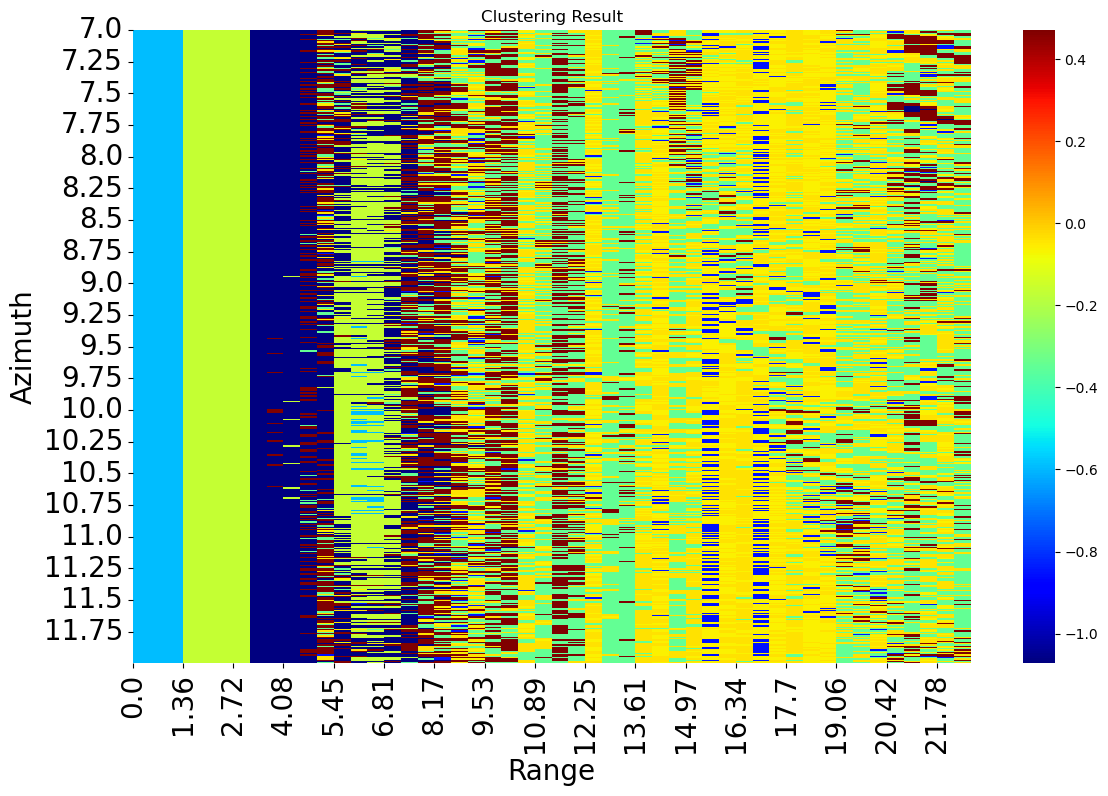

In [19]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# # read the image
# img = plt.imread('tree.jpg')

# # reshaping the pixels matrix
# pixels = np.reshape(img, (img.shape[0]*img.shape[1], 1))
pixels = amp_phase_two_column

# SOM initialization and training
print('training...')
som = MiniSom(2, 4, 2, sigma=1.,
              learning_rate=0.9, neighborhood_function='bubble')  
som.random_weights_init(pixels)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(pixels, 500000, random_order=True, verbose=True)

print('quantization...')
qnt = som.quantization(pixels)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((*amp_data.shape, 2), dtype=np.float64)
for i, q in enumerate(qnt):  # place the quantized values into a new image
    clustered[np.unravel_index(i, shape=(amp_data.shape[0], amp_data.shape[1]))] = q
print('done.')

"""
# # show the result
# plt.figure(figsize=(7, 7))
# plt.figure(1)
# plt.subplot(221)
# plt.title('original')
# plt.imshow(amp_data)
# plt.subplot(222)
# plt.title('result')
# plt.imshow(clustered)

# plt.subplot(223)
# plt.title('initial colors')
# plt.imshow(starting_weights, interpolation='none')
# plt.subplot(224)
# plt.title('learned colors')
# plt.imshow(som.get_weights(), interpolation='none')

# plt.tight_layout()
# # plt.savefig('resulting_images/som_color_quantization.png')
# plt.show()
"""

# heatmapを描く
all_font = 20
plt.figure(figsize=(12, 8))
sns.heatmap(clustered[:,:,1], cmap="jet") 
name = ["", "range [m]", "azimuth [s]"]
dx = d_tau * light_speed / 2 / 2
dy = 0.01
x_step = int(rg_len / 25) + 1
y_step = int(az_len / 20)
plt.xticks(np.arange(0, rg_e_index - rg_s_index, step = x_step), np.round(np.arange(rg_s_index * dx, rg_e_index * dx, step = dx * x_step), 2), fontsize = all_font, rotation = 90)
plt.yticks(np.arange(0, az_e_index - az_s_index, step = y_step), np.round(np.arange(az_s_index * dy, az_e_index * dy, step = dy * y_step), 2), fontsize = all_font)
plt.title(name[0])
plt.xlabel(name[1], fontsize = all_font)
plt.ylabel(name[2], fontsize = all_font)
plt.tight_layout()
plt.xlabel("Range")
plt.ylabel("Azimuth")
plt.title("Clustering Result")